# Searching for the Perfect Cookies

In [221]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import itertools

In [3]:
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from hard_rules import candidate_cookies

In [4]:
from tqdm import tqdm

In [5]:
sns.set(rc={'figure.figsize':(12,5)})

In [87]:
%load_ext autoreload
%autoreload 2

## Reading the data (and some basic preprocessing)

In [5]:
data = pd.read_csv('../Data/10K_HH.csv')

/var/folders/nw/8w_76z_n6fz418hmsps2_rq40000gn/T/ipykernel_60960/1426712498.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../Data/10K_HH.csv')


In [70]:
needed_columns = ['timestamp', 'filename', 'maid', 'hh_id','iiqid', 'partner_id', 'ip', 'iscellip',
       'cellispid', 'domain','is_house_ip_or_source_ip', 'brand', 'model', 'os', 'osversion',
       'browser', 'advertisedbrowser', 'browserversion', 'type', 'is_best_ip']
unnecessary_columns = [c for c in data.columns if c not in needed_columns]

In [71]:
data.drop(unnecessary_columns, axis=1, inplace=True)

In [72]:
data['time'] = pd.to_datetime(data['timestamp'], unit='ms')

In [73]:
data.dropna(inplace=True)

hh_id contains households id and also non-houdsehols.  
The former are strings and the later are integers.   
So we record this in a seperate cell and convert all to str  

In [76]:
data['is_hh'] = data['hh_id'].apply(lambda x: isinstance(x, str))

In [77]:
data.is_hh.value_counts()

True     7502130
False        211
Name: is_hh, dtype: int64

In [79]:
data['hh_id'] = data['hh_id'].astype(str)

Save the preprosecced data

In [80]:
data.to_parquet('10K_HH.parquet')

In [64]:
data = pd.read_parquet('../Data/10K_HH.parquet')

## Lests Start

In [105]:
houses = data['hh_id'].unique()

In [106]:
len(houses)

9729

### Lets start with a sample

In [75]:
small = data.sample(1000)

In [76]:
filtered_small = small.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).filter(lambda x: x['iiqid'].nunique() > 1)

In [77]:
grouped_small = filtered_small.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'iiqid']).agg({'time': ['min', 'max']}).reset_index()

In [78]:
grouped_small.columns = ['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'iiqid', 'min_time', 'max_time']

In [79]:
# filtered_small.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'iiqid']).agg({'time': ['min', 'max']})

In [80]:
grouped_small = grouped_small.sort_values(by=['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'min_time'])

In [81]:
grouped_small['prev_max_time'] = grouped_small.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_time'].shift(1).fillna(pd.Timestamp.min)

In [82]:
grouped_small.head()

,hh_id,brand,model,os,browser,advertisedbrowser,iiqid,min_time,max_time,prev_max_time
0,1280209488,apple,iphone,ios,safari,iOS WebView,K70P06sp1b,2022-12-12 15:14:07.008,2022-12-12 15:14:07.008,1677-09-21 00:12:43.145224193
1,1280209488,apple,iphone,ios,safari,iOS WebView,eSMp1Ne7ex,2022-12-23 11:55:09.401,2022-12-23 11:55:09.401,2022-12-12 15:14:07.008000000
2,1980157490,apple,iphone,ios,safari,iOS WebView,0qUVdNXGOO,2022-12-06 23:49:59.881,2022-12-06 23:49:59.881,1677-09-21 00:12:43.145224193
3,1980157490,apple,iphone,ios,safari,iOS WebView,YkqH6UqMVJ,2023-01-24 14:40:12.558,2023-01-24 14:40:12.558,2022-12-06 23:49:59.881000000
4,3630192075,apple,iphone,ios,safari,iOS WebView,V9RecW5Mdq,2023-01-04 06:01:45.747,2023-01-04 06:01:45.747,1677-09-21 00:12:43.145224193


In [83]:
valid_rows = grouped_small[grouped_small['min_time'] > grouped_small['prev_max_time']]

In [84]:
original_rows_per_hhua = grouped_small.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
valid_rows_per_hhua = valid_rows.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
all_mergable = valid_rows_per_hhua.eq(original_rows_per_hhua)

result = pd.concat([original_rows_per_hhua, all_mergable], axis=1)
result.columns = ['cookies','mergeable'] 
result

,,,,,,cookies,mergeable
hh_id,brand,model,os,browser,advertisedbrowser,,
1280209488,apple,iphone,ios,safari,iOS WebView,2,True
1980157490,apple,iphone,ios,safari,iOS WebView,2,True
3630192075,apple,iphone,ios,safari,iOS WebView,2,True
55ht4SLz3H,google,chrome,windows,chrome desktop,Chrome,3,True
ASfqUTXEJn,apple,iphone,ios,safari,iOS WebView,2,True
B5HFNBBCOF,apple,iphone,ios,safari,iOS WebView,2,False
Bk3sD6P4Fa,apple,iphone,ios,safari,iOS WebView,2,True
HfbL5Tcd5J,apple,iphone,ios,safari,iOS WebView,2,True
HpkzePEbDn,apple,iphone,ios,safari,iOS WebView,2,True


In [96]:
result.reset_index().groupby(['browser', 'cookies']).sum(numeric_only=True)

mergeable
browser        cookies           
chrome desktop 2                3
               3                1
chrome mobile  2                1
               3                1
safari         2               15
               3                1

In [86]:
result.reset_index().groupby(['browser', 'cookies']).count().mergeable

browser         cookies
chrome desktop  2           3
                3           1
chrome mobile   2           1
                3           1
safari          2          17
                3           1
Name: mergeable, dtype: int64

In [87]:
result.pivot_table(values='mergeable', columns='cookies', index='browser', aggfunc=sum, fill_value=0).sort_values(2, ascending=False)

cookies,2,3
browser,,
safari,15,1
chrome desktop,3,1
chrome mobile,1,1


In [88]:
result.pivot_table(values='mergeable', columns='cookies', index='browser', aggfunc='count', fill_value=0).sort_values(2, ascending=False)

cookies,2,3
browser,,
safari,17,1
chrome desktop,3,1
chrome mobile,1,1


### Now for the entire dataset

In [65]:
maid_dict = {'maid': 4, 'third_party': 7}

maid_chosen = 'third_party'

In [127]:
only_relevant_maid = data[data["maid"] == maid_dict[maid_chosen]]

In [128]:
more_than_one = only_relevant_maid.groupby(
        ["hh_id", "brand", "model", "os", "browser", "advertisedbrowser"]
    ).filter(lambda x: x["iiqid"].nunique() > 1)

In [55]:
# more_than_one = only_relevant_maid.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).filter(lambda x: x['iiqid'].nunique() > 1)

In [56]:
# print("{0:.2%}".format(len(more_than_one) / len(data)))

In [129]:
grouped_data = more_than_one.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'iiqid']).agg({'time': ['min', 'max']}).reset_index()

In [130]:
grouped_data.columns = ['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'iiqid', 'min_time', 'max_time']

In [131]:
grouped_data = grouped_data.sort_values(by=['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser', 'min_time'])

In [132]:
grouped_data['prev_max_time'] = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser'])['max_time'].shift(1).fillna(pd.Timestamp.min)

In [133]:
full_valid_rows = grouped_data[grouped_data['min_time'] > grouped_data['prev_max_time']]

In [134]:
original_rows_per_hhua = grouped_data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
valid_rows_per_hhua = full_valid_rows.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).size()
all_mergable = valid_rows_per_hhua.eq(original_rows_per_hhua)

result = pd.concat([original_rows_per_hhua, all_mergable], axis=1)
result.columns = ['cookies','mergeable'] 
result

,,,,,,cookies,mergeable
hh_id,brand,model,os,browser,advertisedbrowser,,
008lj1AMI8,google,chrome,windows,chrome desktop,Chrome,2,False
017VVGbSKq,samsung,sm-a125u,android,chrome mobile,Facebook on Android,2,True
02AntYkc0F,blu,b131dl,android,chrome mobile,Chrome Mobile,2,True
03M6awhGWm,samsung,sm-n975f,android,chrome mobile,Chrome Mobile,2,False
03gbDb0Gsc,google,chrome,windows,chrome desktop,Chrome,2,False
...,...,...,...,...,...,...,...
zvq12WxlGV,apple,safari,macos,safari,Safari,3,False
zxBDRbCP0r,apple,safari,macos,safari,Safari,3,False
zygR659Gbx,microsoft,edge,windows,edge,Edge,2,True


In [139]:
mergable = result.pivot_table(values='mergeable', columns='cookies', index='browser', aggfunc=sum, fill_value=0).sort_values(2, ascending=False)

In [140]:
uq_cookies = result.pivot_table(values='mergeable', columns='cookies', index='browser', aggfunc='count', fill_value=0).sort_values(2, ascending=False)

In [141]:
mergable['+6'] = mergable[[i for i in mergable.columns if i>=6]].sum(axis=1)
mergable.drop([i for i in mergable.columns if isinstance(i, int) and i >=6], axis=1, inplace=True)
mergable.columns = [str(i) for i in mergable.columns]

In [142]:
uq_cookies['+6'] = uq_cookies[[i for i in uq_cookies.columns if i>=6]].sum(axis=1)
uq_cookies.drop([i for i in uq_cookies.columns if isinstance(i, int) and i >=6], axis=1, inplace=True)
uq_cookies.columns = [str(i) for i in uq_cookies.columns]

In [143]:
non_mergable = (uq_cookies - mergable).sort_values(by='2', ascending=False)

In [149]:
uq_cookies.sum(axis=1)

browser
safari             2885
chrome mobile      2401
chrome desktop     3265
edge               1589
firefox desktop     468
android webkit       65
firefox mobile       61
opera                21
msie                  7
samsung               8
chrome                2
tizen browser         1
dtype: int64

#### Let's coount the total counts

In [145]:
uq_cookies

,2,3,4,5,+6
browser,,,,,
safari,1993,510,232,94,56
chrome mobile,1712,348,119,67,155
chrome desktop,1571,723,373,203,395
edge,803,353,184,92,157
firefox desktop,150,90,53,39,136
android webkit,51,7,4,0,3
firefox mobile,23,11,6,4,17
opera,19,2,0,0,0
msie,7,0,0,0,0


#### And plot

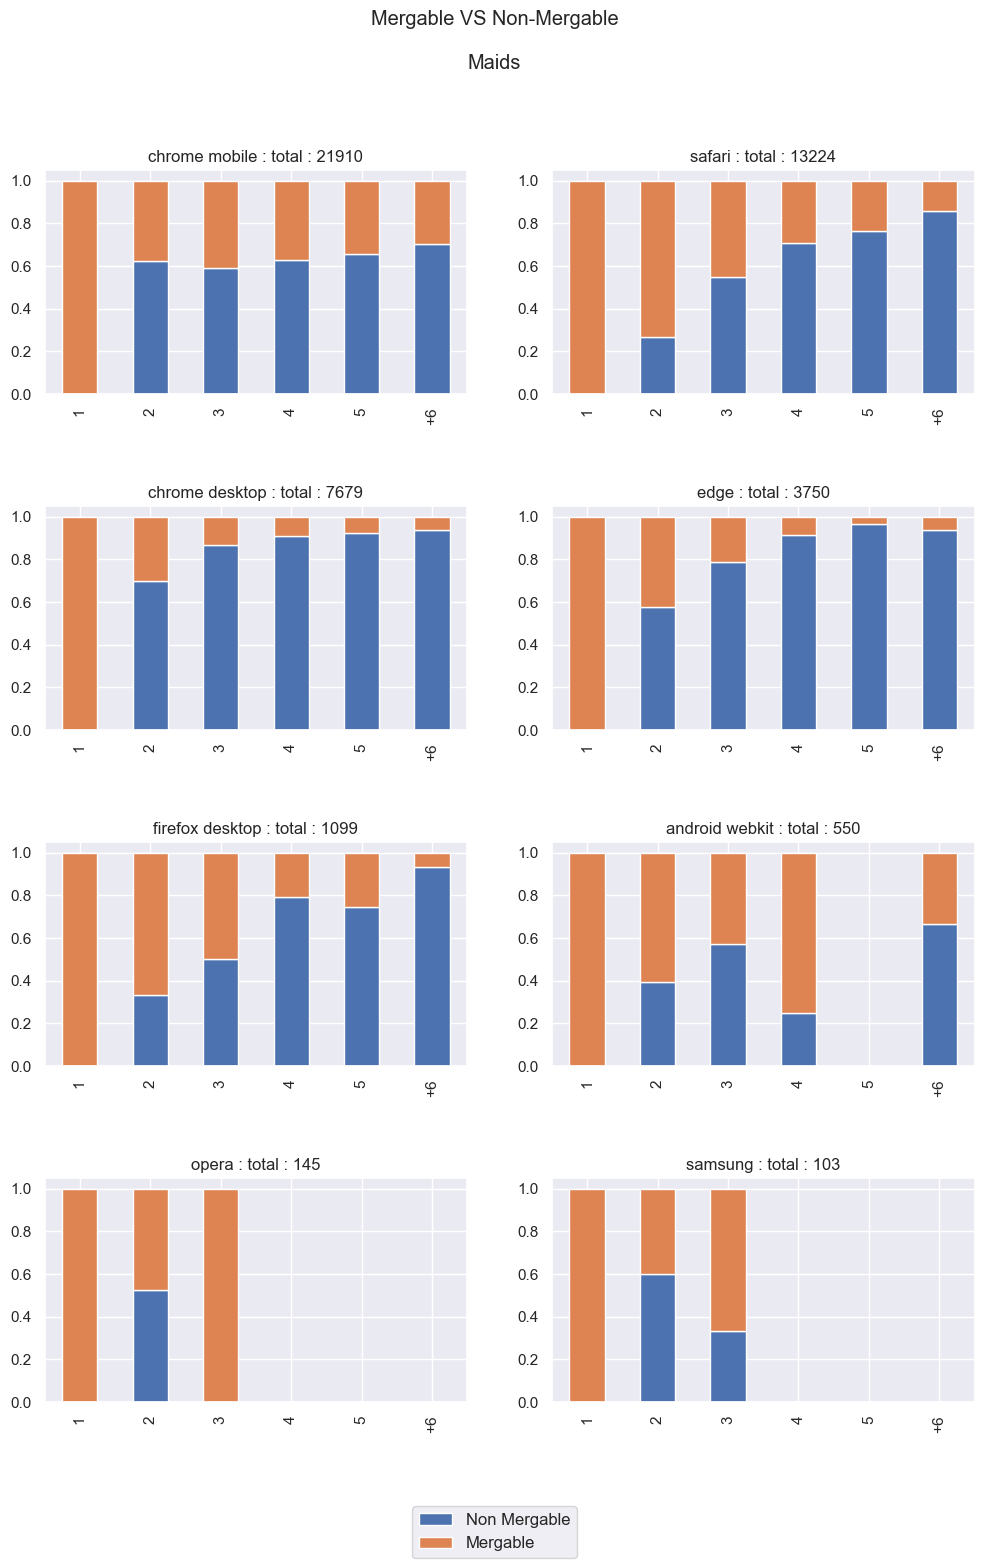

In [86]:
# for b in uq_cookies.index[:8]:
fig, axs = plt.subplots(nrows = 4, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(12)
plt.subplots_adjust(hspace=0.5)
handles, labels = ax.get_legend_handles_labels()
fig.suptitle("Mergable VS Non-Mergable\n\nMaids")
fig.legend(handles, labels, loc='upper center', fontsize='medium', bbox_to_anchor=(0.5, 0.05))

for i, b in enumerate(uq_cookies.index[:8]):
    ax = axs.flatten()[i]
    browser_comparison = pd.concat([non_mergable.loc[b], mergable.loc[b]], axis=1)
    browser_comparison.columns = ['Non Mergable', 'Mergable']
    browser_comparison_normalized = browser_comparison.div(browser_comparison.sum(axis=1), axis=0)
    browser_comparison_normalized.plot(kind='bar', stacked=True, ax=ax, legend=0)
    ax.title.set_text(f"{b} : total : {uq_cookies.loc[b].sum()}")
    ax.set_xlabel("")

### Just some basic numbers (data size)

In [186]:
four_or_seven = sum((data['maid']==4) | (data['maid']==7))
print("{0:.2%}".format(four_or_seven / len(data)))

60.31%


In [191]:
more_than_one_4or7 = data.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).filter(lambda x: x['iiqid'].nunique() > 1)

In [193]:
four_or_seven = sum((more_than_one_4or7['maid']==4) | (more_than_one_4or7['maid']==7))
print("{0:.2%}".format(four_or_seven / len(data)))

28.88%


In [198]:
four_seven = data[(data['maid']==4) | (data['maid']==7)]
more_than_one_47 = four_seven.groupby(['hh_id', 'brand', 'model', 'os', 'browser', 'advertisedbrowser']).filter(lambda x: x['iiqid'].nunique() > 1)

In [199]:
print("{0:.2%}".format(len(four_seven) / len(data)))
print("{0:.2%}".format(len(more_than_one_47) / len(four_seven)))
print("{0:.2%}".format(len(more_than_one_47) / len(data)))

60.31%
46.75%
28.19%


In [200]:
len(more_than_one_47)

2115209

## Testing my module

In [115]:
from perfect_cookies import preprocessing, count_perfect_coolies

In [211]:
maid_dict = {'maid': 4, 'third_party': 7}

maid_chosen = 'third_party'

In [212]:
df = preprocessing(data)

In [213]:
%%time
m, n, t = count_perfect_coolies(df, maid_dict[maid_chosen])

CPU times: user 4.59 s, sys: 1.22 s, total: 5.81 s
Wall time: 6.26 s


In [214]:
HH_UA = [
        "hh_id",
        "brand",
        "model",
        "os",
        "browser",
        "advertisedbrowser",
    ]

CPU times: user 1.4 s, sys: 436 ms, total: 1.84 s
Wall time: 1.84 s


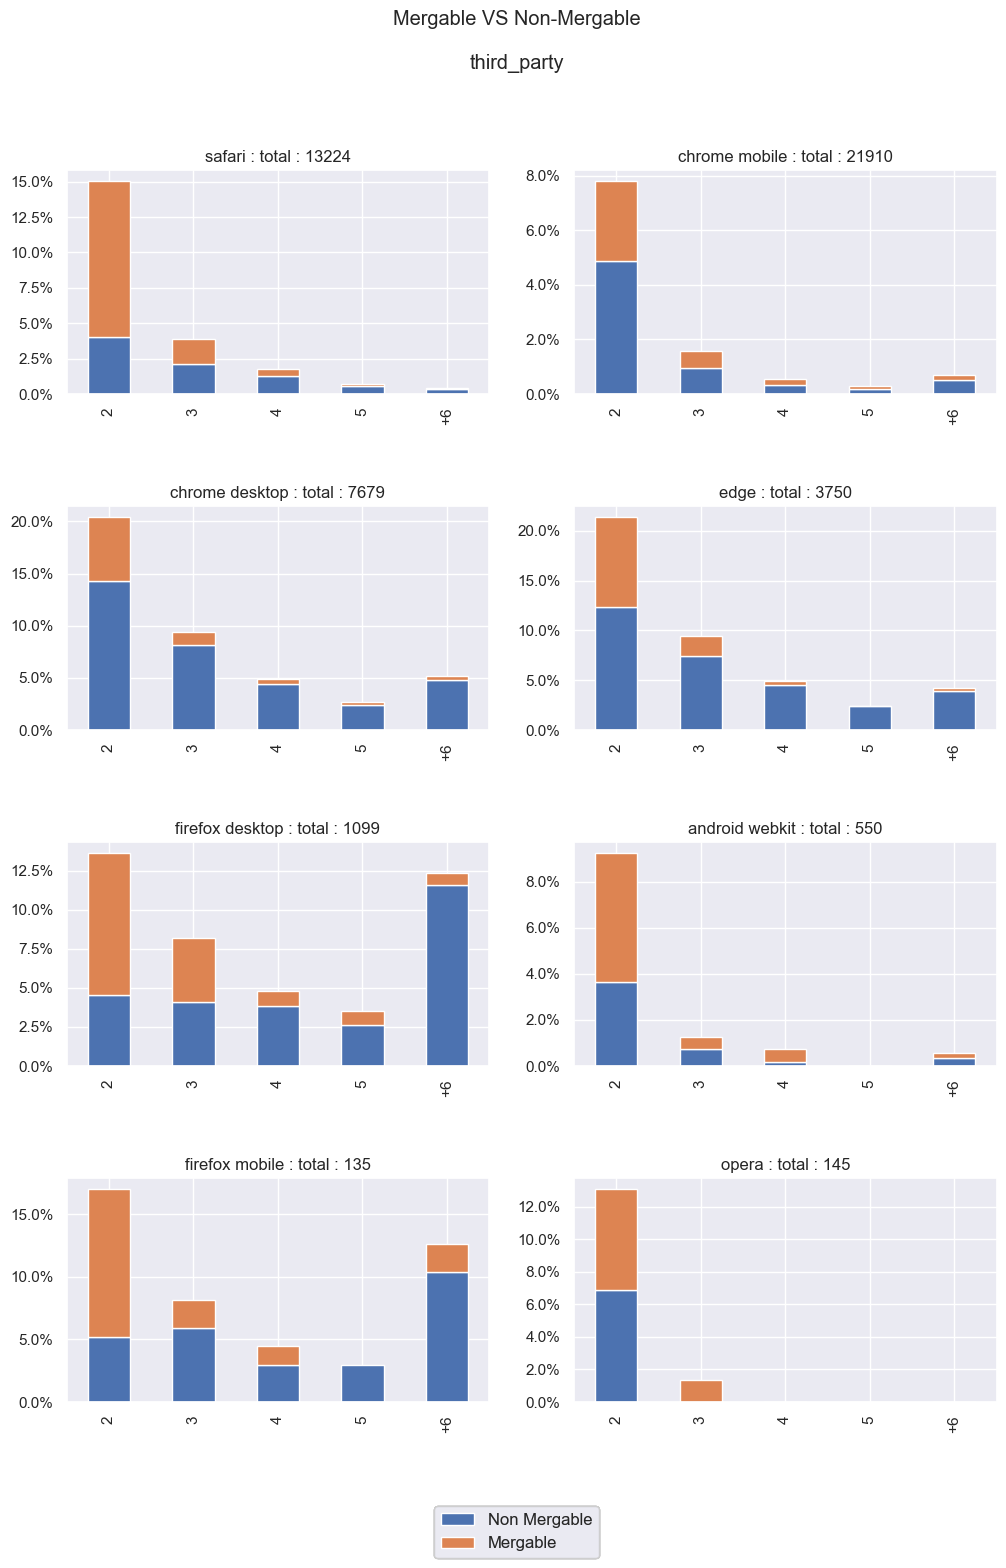

In [224]:
%%time

fig, axs = plt.subplots(nrows = 4, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(12)
plt.subplots_adjust(hspace=0.5)
fig.suptitle(f"Mergable VS Non-Mergable\n\n{maid_chosen}")

total_count = df[df.maid==maid_dict[maid_chosen]].groupby(HH_UA).iiqid.nunique().reset_index()

for i, b in enumerate(t.index[:8]):
    all_unique_hh_ua = total_count[total_count["browser"]==b].iiqid.value_counts().sum()
    
    browser_comparison = pd.concat([n.loc[b], m.loc[b]], axis=1)
    browser_comparison.columns = ['Non Mergable', 'Mergable']
    browser_comparison_normalized = browser_comparison.div(all_unique_hh_ua, axis=0)

    ax = axs.flatten()[i]
    browser_comparison_normalized.plot(kind='bar', stacked=True, ax=ax, legend=0)
    ax.title.set_text(f"{b} : total : {all_unique_hh_ua}")
    ax.set_xlabel("")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', fontsize='medium', bbox_to_anchor=(0.5, 0.05))    

In [120]:
print('Chrome')
print(len(data[(data['maid']==7) & ((data['browser']=='chrome mobile') | (data['browser']=='chrome desktop'))]))
print(data[(data['maid']==7) & ((data['browser']=='chrome mobile') | (data['browser']=='chrome desktop'))].iiqid.nunique())

Chrome
2971722
36216


In [121]:
print('Safari')
print(len(data[(data['maid']==7) & (data['browser']=='safari')]))
print(data[(data['maid']==7) & (data['browser']=='safari')].iiqid.nunique())

Safari
88016
11044


In [150]:
HH_UA = [
        "hh_id",
        "brand",
        "model",
        "os",
        "browser",
        "advertisedbrowser",
    ]

In [195]:
total_count = df[df.maid==7].groupby(HH_UA).iiqid.nunique().reset_index()

In [196]:
total_count[total_count["hh_id"]=="008lj1AMI8"]

,hh_id,brand,model,os,browser,advertisedbrowser,iiqid
0,008lj1AMI8,apple,iphone,ios,safari,Mobile Safari,1
1,008lj1AMI8,apple,safari,macos,safari,Safari,1
2,008lj1AMI8,google,chrome,windows,chrome desktop,Chrome,2
3,008lj1AMI8,samsung,sm-s908u,android,chrome mobile,Chrome Mobile,1


In [199]:
len(total_count[total_count["browser"]=="safari"])

13224

In [207]:
b = "safari"
total_count[total_count["browser"]==b].iiqid.value_counts().sum()

13224

hh_id       brand      model     os       browser         advertisedbrowser  
008lj1AMI8  apple      iphone    ios      safari          Mobile Safari          1
                       safari    macos    safari          Safari                 1
            google     chrome    windows  chrome desktop  Chrome                 2
            samsung    sm-s908u  android  chrome mobile   Chrome Mobile          1
00C30KAqMf  microsoft  edge      windows  edge            Edge                   1
                                                                                ..
zzyXvF318v  apple      iphone    ios      safari          Mobile Safari          2
            google     chrome    windows  chrome desktop  Chrome                 1
            microsoft  edge      windows  edge            Edge                   1
            samsung    sm-s906u  android  chrome mobile   Chrome Mobile          1
                                                          Facebook on Android    1
Name: iiq